In [40]:
# !unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
# !unzip ../input/diabetic-retinopathy-detection/sampleSubmission.csv.zip

In [41]:
!pip install -U --pre efficientnet >> /dev/null

In [42]:
import pandas as pd, numpy as np
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import re, math
import time
from sklearn.utils import class_weight

In [43]:
DEVICE = "TPU"

TFREC_DIR = KaggleDatasets().get_gcs_path('db-stylized-tfrecords')
# TFREC_DIR = KaggleDatasets().get_gcs_path('tfrecord512')
# number of folds for CV
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD 
# CHOOSE 128, 192, 256, 384, 512, 768 

IMG_SIZES = 256

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]


# tune it, dependes on Image, size, TPU or GPU
BATCH_SIZE = 32

EPOCHS = 15

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 5

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = 1/FOLDS

NUM_CLASSES = 5

In [44]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [45]:
# adding some data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # introduced in TF 2.3
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

In [46]:
# not using metadata (only image, for now)
def read_labeled_tfrecord(example, __return_only_label):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    label = example['label']
    
    if __return_only_label:
        return label
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    
    return image, patient_id, side

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [47]:
def load_dataset(filenames, labeled=True, ordered=False, return_only_label=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_labeled_tfrecord(example, __return_only_label=return_only_label))
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


# CHANGE GET_TEST_DATASET TO GIVE A 10% SUBSET OF THE TRAINING DATASET

def get_training_dataset(filenames, _return_only_label=False):
    dataset = load_dataset(filenames, labeled=True, return_only_label=_return_only_label)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE*REPLICAS)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.cache()
    dataset = dataset.map(read_unlabeled_tfrecord)    
    dataset = dataset.batch(BATCH_SIZE*REPLICAS)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [48]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    return lr_callback

In [49]:
y_train = np.array(pd.read_csv('./trainLabels.csv')['level'])
w_j = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), w_j))
class_weights

{0: 0.27218907400232467,
 1: 2.875644699140401,
 2: 1.3275132275132275,
 3: 8.047193585337915,
 4: 9.922598870056497}

In [50]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = 256, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
#     x = data_augmentation(inp)
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='noisy-student', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
  

    METRICS = [
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    ]

    model.compile(optimizer = opt, loss = loss, metrics=METRICS)
    
    return model

In [51]:
# ds_weights = get_training_dataset(files_train, _return_only_label=True)

In [52]:
# yy = [x for x in iter(ds_weights)]

In [53]:
# y_train = np.array([target.numpy() for target in iter(ds_weights.unbatch())])

In [54]:
# constant to customize output
SHOW_FILES = True
VERBOSE = 1
PLOT = 1

skf = KFold(n_splits = FOLDS, shuffle = True, random_state=42)

# for others investigations
# we store all the history
histories = []

# these will be split in folds
num_total_train_files = len(tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec'))

files_test = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    tStart = time.time()
    
    # display fold info
    print('#'*60) 
    print('#### FOLD', fold+1)
    
    print('#### Image Size %i, EfficientNet B%i, batch_size %i'%
          (IMG_SIZES, EFF_NETS, BATCH_SIZE*REPLICAS))
    print('#### Epochs: %i' %(EPOCHS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([TFREC_DIR + '/train%.2i*.tfrec'%x for x in idxT])
    print(len(files_train))
    files_test.append(files_train[10])
    files_test.append(files_train[11])
    files_train = files_train[0:10]
    
    np.random.shuffle(files_train) 
    print('#'*60)
    
    files_valid = tf.io.gfile.glob([TFREC_DIR + '/train%.2i*.tfrec'%x for x in idxV])
    
    if SHOW_FILES:
        print('Number of training images', count_data_items(files_train))
        print('Number of validation images', count_data_items(files_valid))
        
    # BUILD MODEL
    if DEVICE=='TPU':
        # to avoid OOM
        tf.tpu.experimental.initialize_tpu_system(tpu)
            
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
        
    # callback to save best model for each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
                'fold-%i.h5'%fold, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=True, mode='auto', save_freq='epoch')
    
    csv_logger = tf.keras.callbacks.CSVLogger('training_retina-%i.log'%fold)
    
    y_train = np.array(pd.read_csv('./trainLabels.csv')['level'])
    w_j = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), w_j))

    # TRAIN
    history = model.fit(
        get_training_dataset(files_train), 
        epochs=EPOCHS, 
        callbacks = [sv, get_lr_callback(BATCH_SIZE), csv_logger], 
        steps_per_epoch = count_data_items(files_train)/BATCH_SIZE//REPLICAS,
        validation_data = get_training_dataset(files_valid), 
        validation_steps = count_data_items(files_valid)/BATCH_SIZE//REPLICAS,
        verbose=VERBOSE,
#         class_weight = class_weights
    )
    
    # save all histories
    histories.append(history)
    
    tElapsed = round(time.time() - tStart, 1)
    
    print(' ')
    print('Time (sec) elapsed for fold: ', tElapsed)
    print('...')
    print('...')

############################################################
#### FOLD 1
#### Image Size 256, EfficientNet B5, batch_size 256
#### Epochs: 15
12
############################################################
Number of training images 20710
Number of validation images 6213
Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
80/80 [==============================] - 180s 550ms/step - loss: 1.5529 - accuracy: 0.3340 - val_loss: 1.6726 - val_accuracy: 0.0864

Epoch 00001: val_loss improved from inf to 1.67263, saving model to fold-0.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 6.8e-05.
80/80 [==============================] - 31s 394ms/step - loss: 1.0038 - accuracy: 0.9616 - val_loss: 0.8710 - val_accuracy: 0.9943

Epoch 00002: val_loss improved from 1.67263 to 0.87101, saving model to fold-0.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000131.
80/80 [==============================] - 31s 393ms/step -

In [55]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss fold n. ' + str(fold + 1) )
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

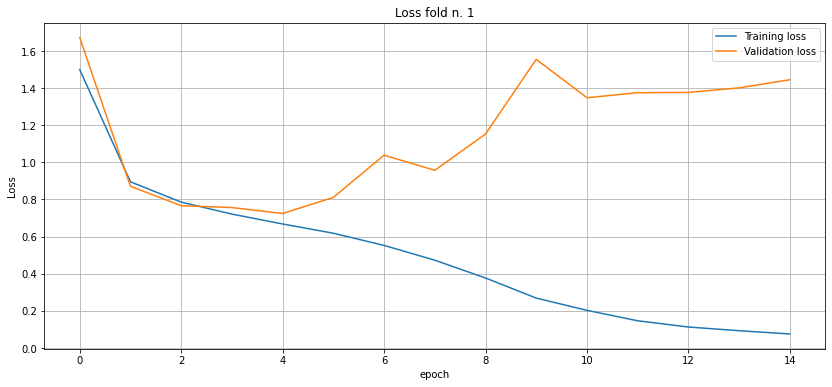

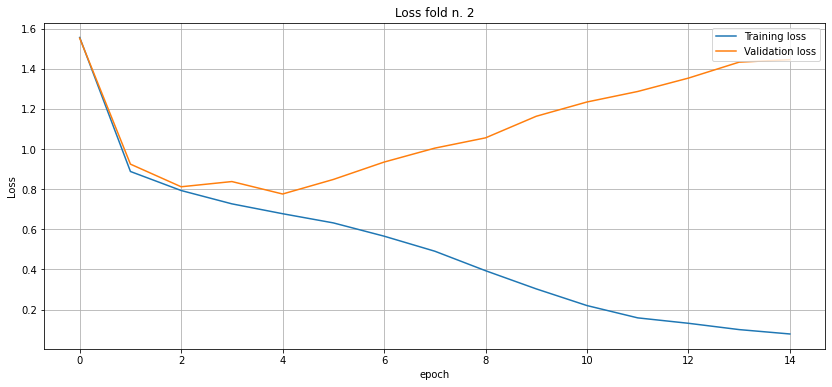

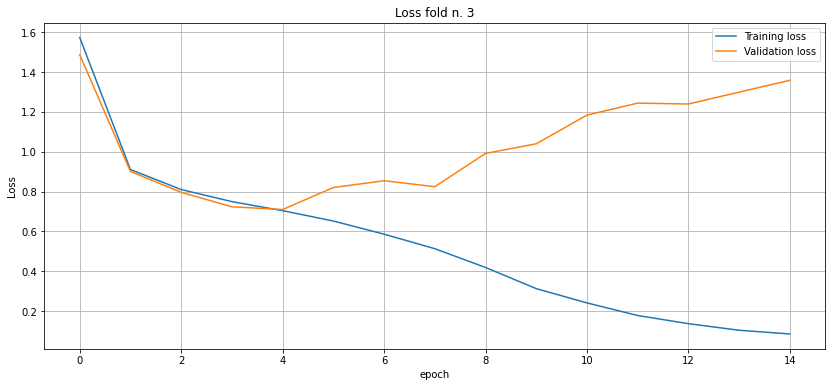

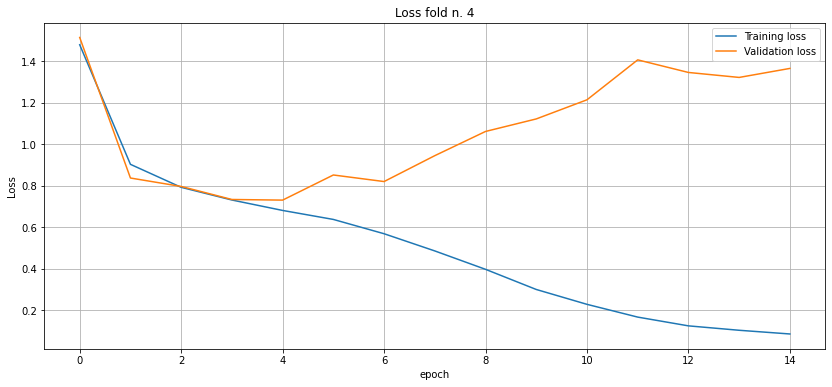

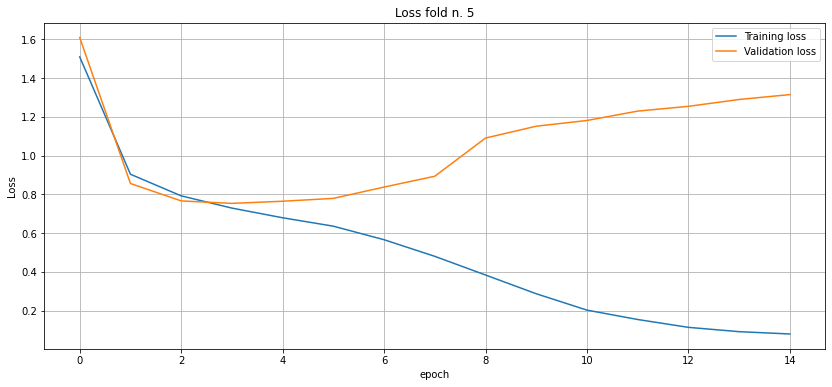

In [56]:
for fold in range(FOLDS):
    plot_loss(histories[fold])

In [57]:
def plot_acc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['accuracy'], label='Training accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy fold n. ' + str(fold + 1) )
    plt.legend(loc='lower right')
    plt.ylabel('Acc')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

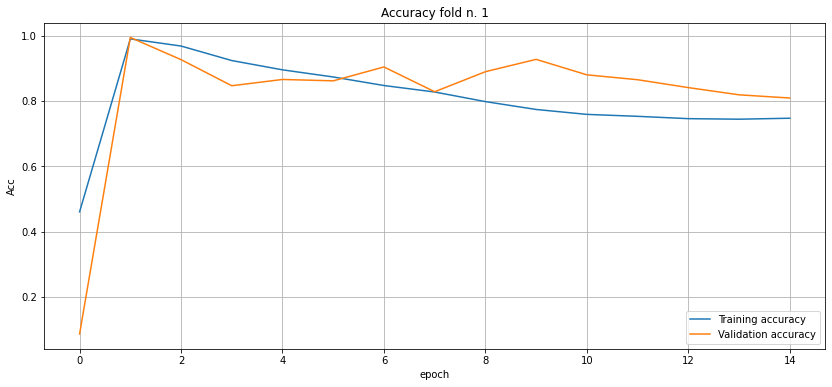

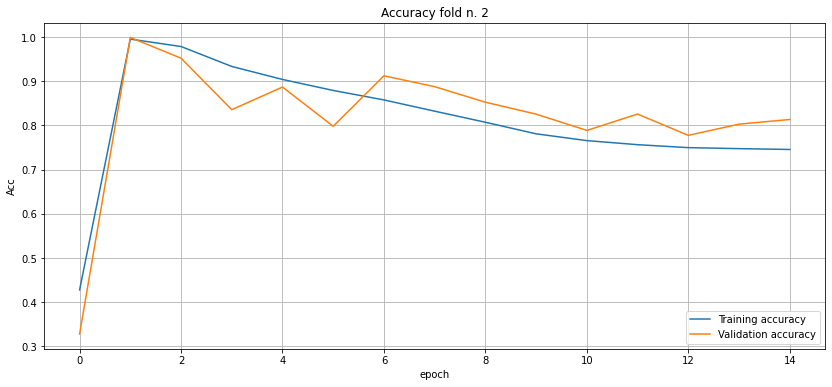

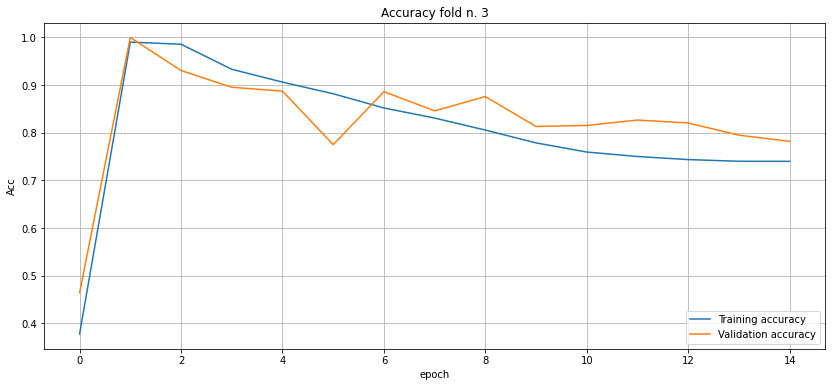

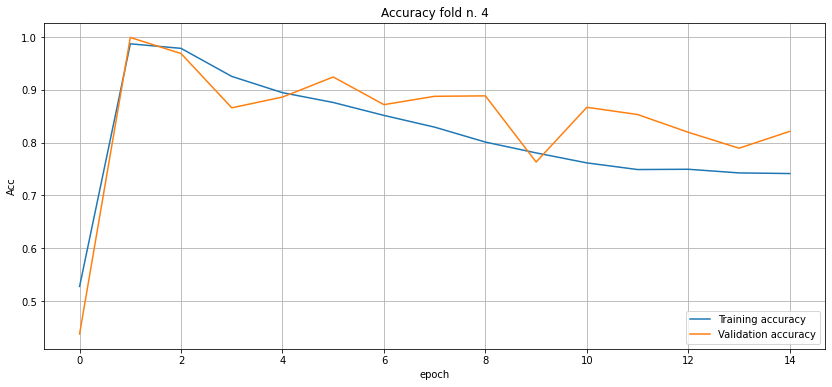

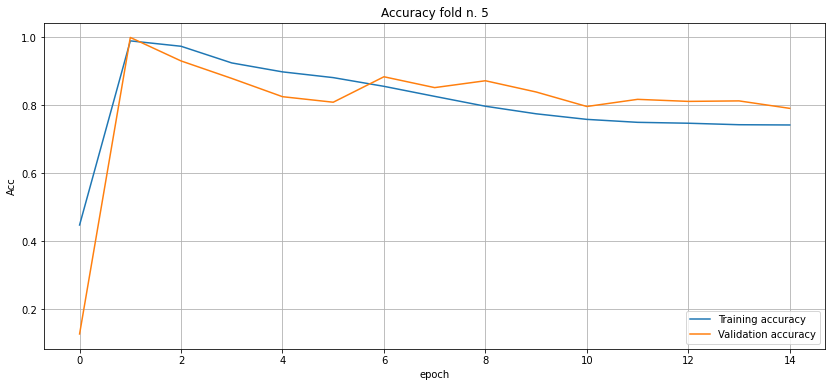

In [58]:
for fold in range(FOLDS):
    plot_acc(histories[fold])

In [59]:
files_test = tf.io.gfile.glob(KaggleDatasets().get_gcs_path('diabetic-tfrecords') + '/train*.tfrec')[0:1]

num_total_test_files = count_data_items(files_test)
print('Total test files:', num_total_test_files)
preds = np.zeros((num_total_test_files, NUM_CLASSES))

wi = [1/FOLDS]*FOLDS

avg_acc = 0

for fold in range(FOLDS):
    model.load_weights('fold-%i.h5'%fold)
    
#     test_loss, test_acc = model.evaluate(get_test_dataset(files_test), verbose = 1, batch_size = 4*BATCH_SIZE,
#                                         steps = num_total_test_files/4*BATCH_SIZE//REPLICAS)
    
    out = model.predict(get_test_dataset(files_test), verbose = 1,
                                        steps = num_total_test_files/BATCH_SIZE/REPLICAS)
    preds += out * wi[fold]
#     print('Test accuracy fold n.', fold+1, ': ', round(test_acc, 4))
#     avg_acc += test_acc * wi[fold]

sparse_preds = np.array([np.argmax(x) for x in preds])
# print('Average accuracy: ', round(avg_acc,4))

Total test files: 2000
7/7 [==============================] - 2s 294ms/step


In [60]:
ds_test = get_test_dataset(files_test)
img_names = [(img_name.numpy(), side.numpy()) for img, img_name, side in iter(ds_test.unbatch())]

In [61]:
iname_list = []
for x in img_names:
    if x[1]==0:
        iname_list.append(str(x[0]) + '_left')
    else:
        iname_list.append(str(x[0]) + '_right')        

In [62]:
import csv
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image", "level"])
    for i in range(len(sparse_preds)):
        writer.writerow([iname_list[i], sparse_preds[i]])

In [63]:
submission = pd.read_csv('submission.csv')
submission.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,0


[0 2 4]


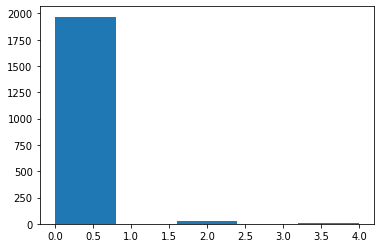

2000


In [64]:
print(np.unique(submission.level))
plt.hist(submission.level,bins=5)
plt.show()

print(len(submission))

In [65]:
# %cd /kaggle/working
# from IPython.display import FileLink -> FileLink(r'submission.csv')